In [81]:
#| code-summary: Load Packages
#| code-fold: true

# numerical calculation & data frames
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import plotly.express as px

# statistics
import statsmodels.api as sm


In [ ]:
#| echo: false
from IPython.display import display, HTML
HTML('<style>.output {flex-direction: row;}</style>')
pd.options.display.notebook_repr_html = False

In [82]:
#| code-summary: Options
#| code-fold: true

# pandas options
pd.options.display.precision = 2
pd.options.display.float_format = '{:.2f}'.format  # pd.reset_option('display.float_format')

# Numpy options
np.set_printoptions(precision = 2, suppress=True)

## Q1
각 도착지에 따른 비행거리와 도착지연시간과의 관계를 알아보고자 함.

1. Group flights by destination.
2. Summarise to compute distance, average delay, and number of flights.
3. Filter to remove noisy points and Honolulu airport, which is almost twice as far away as the next closest airport.


In [83]:
flights = sm.datasets.get_rdataset("flights", "nycflights13").data.drop(columns="time_hour")

In [84]:
by_dest = flights.groupby("dest")

In [97]:
delay = by_dest[["distance", "arr_delay"]].agg(["count", "mean"])
delay.head()

     distance         arr_delay      
        count    mean     count  mean
dest                                 
ABQ       254 1826.00       254  4.38
ACK       265  199.00       264  4.85
ALB       439  143.00       418 14.40
ANC         8 3370.00         8 -2.50
ATL     17215  757.11     16837 11.30

In [98]:
delay.columns = ['_'.join(col_agg) for col_agg in delay.columns]
delay.drop(columns="arr_delay_count", inplace=True)
delay.columns = ["count", "dist", "delay"]
delay = delay.reset_index()

In [99]:
delay.head()

  dest  count    dist  delay
0  ABQ    254 1826.00   4.38
1  ACK    265  199.00   4.85
2  ALB    439  143.00  14.40
3  ANC      8 3370.00  -2.50
4  ATL  17215  757.11  11.30

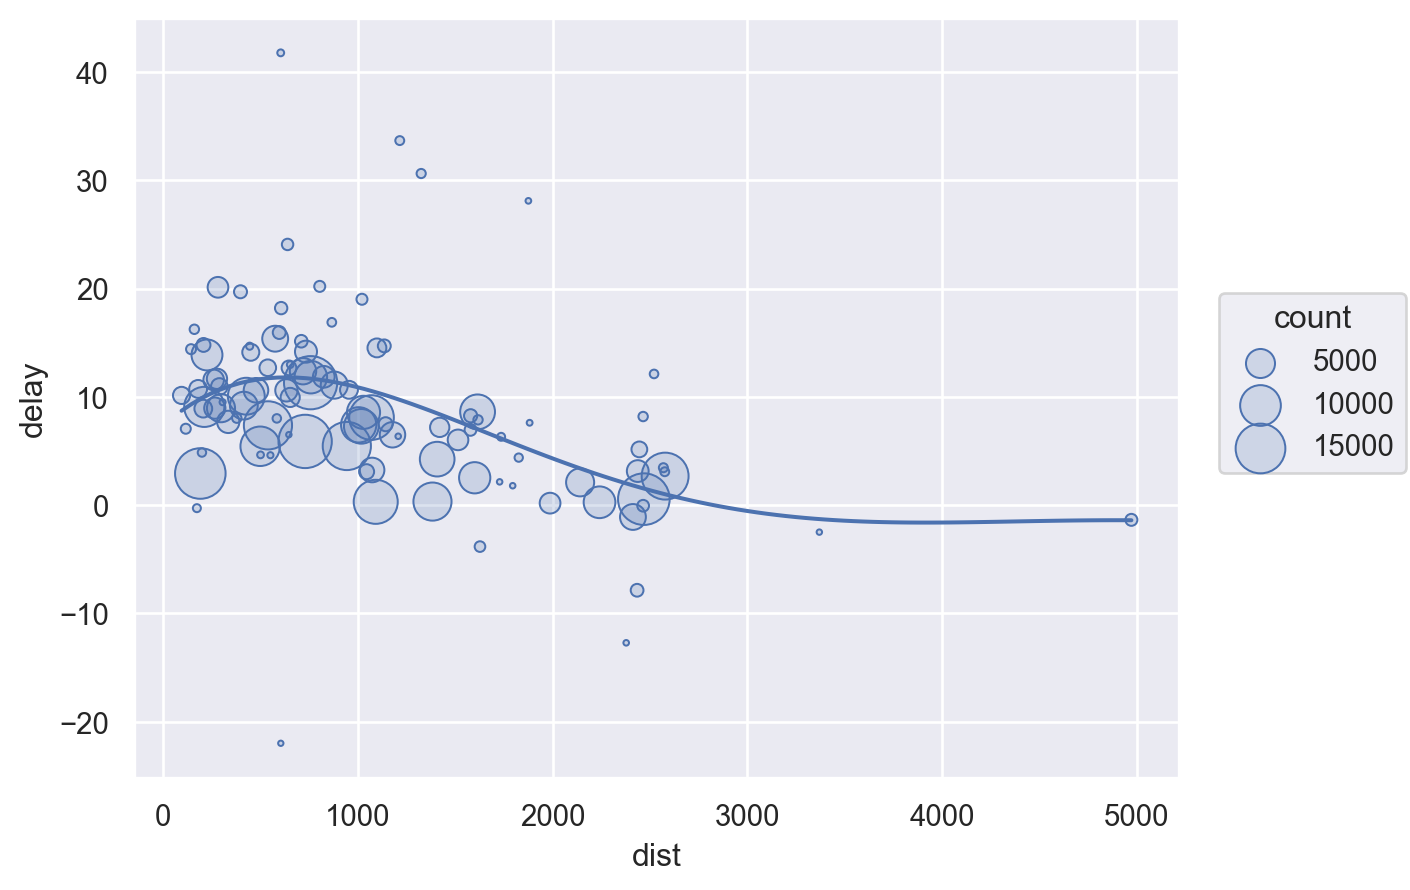

In [100]:
(
    so.Plot(delay, x="dist", y="delay")
    .add(so.Dots(), pointsize="count")
    .add(so.Line(), so.PolyFit(5))
    .scale(pointsize=(2, 20))
)

불필요한 자료를 제거하고 시각화하는 것이 유리

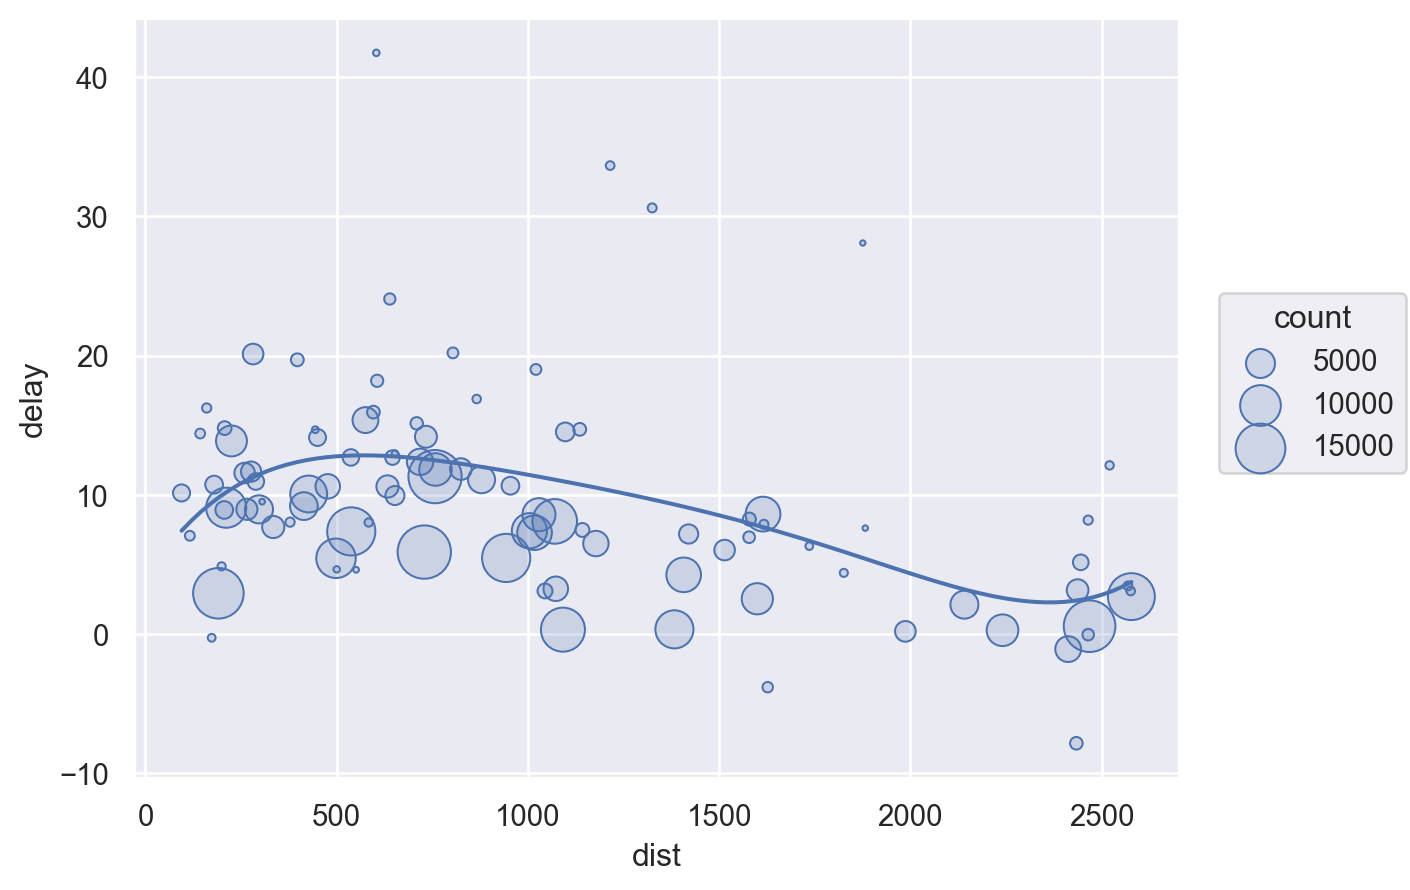

In [101]:
# Filter to remove noisy points and Honolulu airport
delay_sub = delay.query('count > 20 & dest != "HNL"')
(
    so.Plot(delay_sub, x="dist", y="delay")
    .add(so.Dots(), pointsize="count")
    .add(so.Line(), so.PolyFit(5))
    .scale(pointsize=(2, 20))
)

In [111]:
idx = (delay["count"] > 20) & (delay["dest"] != "HNL")
delay["incl"] = np.where(idx, "out", "in")

In [113]:
delay.head()

  dest  count    dist  delay incl
0  ABQ    254 1826.00   4.38  out
1  ACK    265  199.00   4.85  out
2  ALB    439  143.00  14.40  out
3  ANC      8 3370.00  -2.50   in
4  ATL  17215  757.11  11.30  out

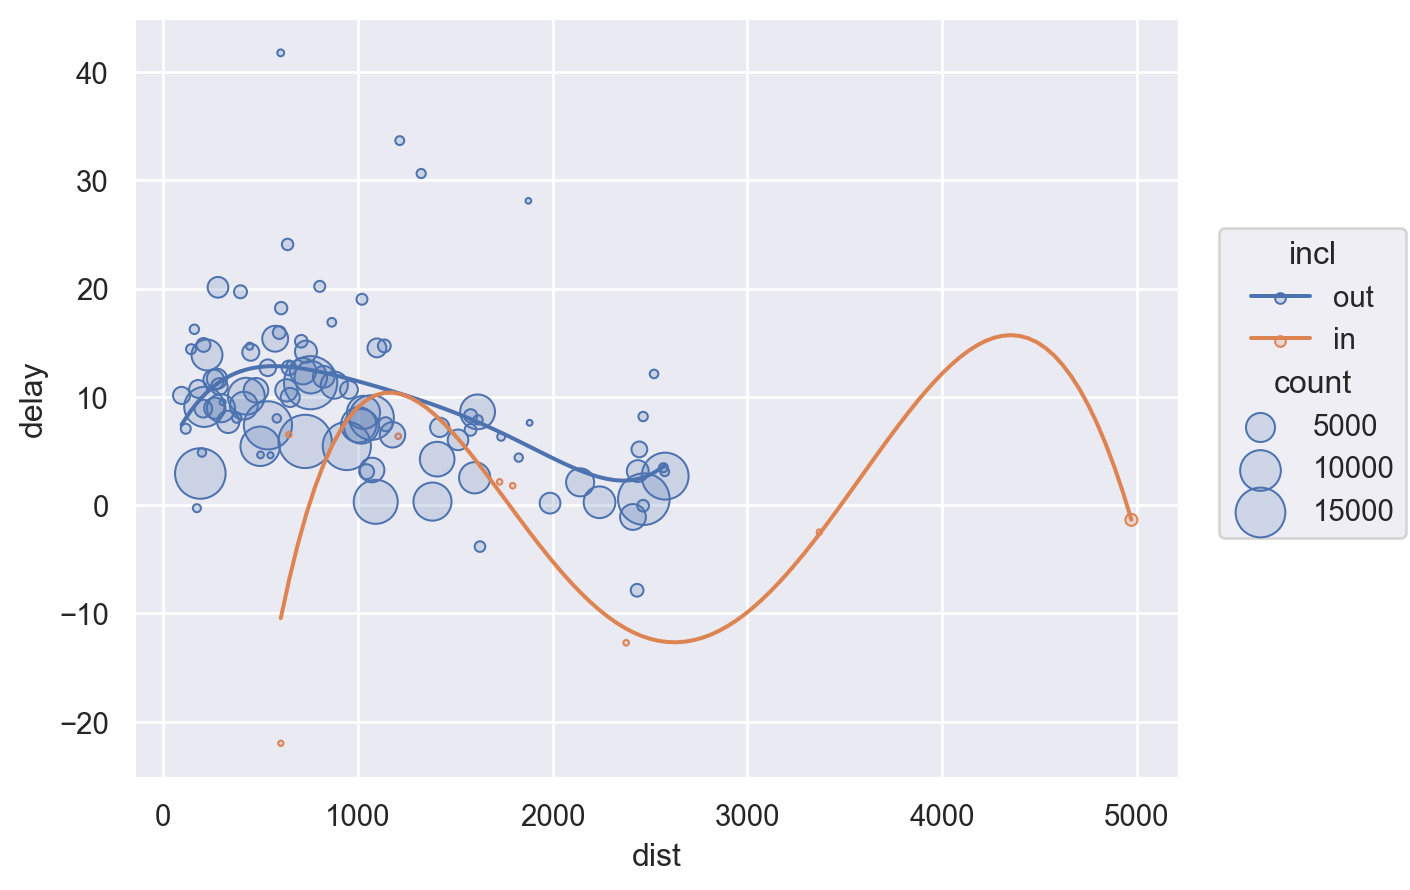

In [114]:
(
    so.Plot(delay, x="dist", y="delay", color="incl")
    .add(so.Dots(), pointsize="count")
    .add(so.Line(), so.PolyFit(5))
    .scale(pointsize=(2, 20))
)

## Q2

항공기의 비행횟수와 연착시간의 관계를 살펴보고자 함.

먼저, 평균적으로 가장 연착시간이 큰 항공기(tail number로 구분)를 살펴보고자 함.

- Count를 사용하여 샘플 수가 작은 케이스들 혹은 극단치들을 제거해서 살펴보기  
- `agg()`와 같이 여러 값들을 aggregate할 시, “갯수”를 같이 살펴보는 것이 좋음 (`count()`, `size()`)